```text
TECHNICAL PROCESSES

temporarily split into 3 blocks:
    downloading and processing data by running a batch script
    loading processed ready-to-use csv files
    setting up the dataframes necessary for further analysis and visualization


THIS IS ONLY A REFORMATTING SUGGESTION, WHICH AIMS TO MAKE THE NOTEBOOK MORE READABLE AND STREAMLINED FOR THE USER
IT IS NOT THE UPDATE OF THE PREVIOUS PROJECT NOTEBOOK FILE, BUT MERELY A PROPOSED ALTERNATIVE, THEREFORE IT HAS BEEN COMMITTED AS A SEPARATE FILE
THE DATA ANALYSIS / VISUALIZATION HAS NOT BEEN CHANGED, EXCEPT FOR UPDATING CERTAIN VARIABLE NAMES, BUT FUNCTIONALITY HAS REMAINED UNCHANGED
```

In [4]:
import subprocess
import pandas as pd
import os
from datetime import datetime
import sys

# downloads and updates data

exclude = {"transform_universal.py"}

scripts_dir = os.getcwd()

scripts = sorted(
    f for f in os.listdir(scripts_dir)
    if f.endswith(".py") and f not in exclude
)

for f in scripts:
    print(f"Running: {f}")
    subprocess.run([sys.executable, f], cwd=scripts_dir, check=True)

print("All scripts finished.")


Running: download_static.py
Running: transform_calendar_calendar_dates.py
Running: transform_routes.py
Running: transform_stop_times.py
Running: transform_stops.py
Running: transform_transfers.py
Running: transform_trips.py
All scripts finished.


In [5]:
# loading csv files
data = {}
for name in ["stops_processed.csv", "routes_processed.csv", "trips_processed.csv", "stop_times_processed.csv", "calendar_processed.csv", "calendar_dates_processed.csv", "transfers_processed.csv"]:
    df = pd.read_csv(os.path.join("data/processed",name),low_memory=False)
    name = name[:-4]
    data[name] = df

In [6]:
# setting up dataframes

stops_df          = data["stops_processed"]
routes_df         = data["routes_processed"]
trips_df          = data["trips_processed"]
stop_times_df     = data["stop_times_processed"]
calendar_df       = data["calendar_processed"]
calendar_dates_df = data["calendar_dates_processed"]
transfers_df      = data["transfers_processed"]

# merging dataframes

route_type_df     = routes_df[["route_type", "route_id"]]
route_type_df     = pd.merge(route_type_df, trips_df[['route_id', 'trip_id']], on='route_id')
route_type_df     = pd.merge(route_type_df, stop_times_df[['stop_id', 'trip_id']], on='trip_id')
route_type_df     = pd.merge(route_type_df, stops_df[['stop_id', 'stop_name']], on='stop_id')
trips_trans       = pd.merge(trips_df, routes_df[["route_type", "route_id"]], on = "route_id")
stop_times_trans  = pd.merge(stop_times_df, trips_trans[["route_type", "trip_id"]], on = "trip_id")
stop_trans        = pd.merge(stops_df, stop_times_trans[["route_type", "stop_id"]], on = "stop_id")



## HIGHEST VISIBILITY

In [7]:
# high-visibility dataframes

trips_count = pd.DataFrame(stop_times_df.groupby('stop_id')['trip_id'].nunique())
trips_count


,trip_id
stop_id,
T53041,85
T53047,476
T53051,32
T53068,44
T53097,60
...,...
U999Z2P,84
U99Z1P,643
U99Z2P,629


In [83]:
high_visibility = stops_df[["stop_id", "stop_name"]]
high_visibility_merged = pd.merge(high_visibility, trips_count, on='stop_id')
high_visibility_merged = high_visibility_merged.groupby("stop_name")["trip_id"].sum().sort_values(ascending=False).reset_index()
high_visibility_merged.head(10)

,stop_name,trip_id
0,Želivského,7597
1,Smíchovské nádraží,6981
2,Anděl,6940
3,Palmovka,5986
4,Kobylisy,5902
5,Lihovar,5886
6,Černý Most,5769
7,Karlovo náměstí,5492
8,Letňany,5307
9,Florenc,5190


In [75]:
# trying to sort it per route type
high = pd.merge(high_visibility_merged, route_type_df[["stop_name", "route_type"]], on = "stop_name")
high = high.drop_duplicates()
high.head(30)

,stop_name,trip_id,route_type
0,Želivského,7597,1
1378,Želivského,7597,0
4399,Želivského,7597,3
7597,Smíchovské nádraží,6981,1
8566,Smíchovské nádraží,6981,0
9414,Smíchovské nádraží,6981,3
14578,Anděl,6940,1
15546,Anděl,6940,0
19857,Anděl,6940,3
21518,Palmovka,5986,1


## LONGEST EXPOSURE

### 1. longest amount of time

In [67]:
def time_to_seconds(t):
    h, m, s = map(int, t.split(':'))
    return h*3600 + m*60 + s

def seconds_to_time(seconds):
    # Convert to integer (in case it's float)
    seconds = int(seconds)
    
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    
    # Format as HH:MM:SS with leading zeros
    return f"{hours:02d}:{minutes:02d}:{secs:02d}"

work flow:
- groupby trip_id
- find the first and last row per unique trip_id
- convert to seconds
- find the difference
- average per route_id

In [68]:
## defining first rows and compusing seconds ##
first_rows = stop_times_df.loc[stop_times_df.groupby('trip_id')['arrival_time'].idxmin()]

first_rows = first_rows[["trip_id", "arrival_time"]]
first_rows['arrival_seconds'] = (
    first_rows['arrival_time']
    .apply(time_to_seconds)
)

In [69]:
## defining last rows and computing seconds ## 
last_rows  = stop_times_df.loc[stop_times_df.groupby('trip_id')['arrival_time'].idxmax()]

last_rows = last_rows[["trip_id", "arrival_time"]]
last_rows['arrival_seconds'] = (
    last_rows['arrival_time']
    .apply(time_to_seconds)
)

In [70]:
## computing duration per trip_id ##
duration_series = (last_rows.set_index("trip_id")["arrival_seconds"] - first_rows.set_index("trip_id")["arrival_seconds"])

duration = duration_series.reset_index()  # trip_id becomes a column
duration = duration.rename(columns={"arrival_seconds": "duration_seconds"})

duration = pd.merge(duration, trips_df[['trip_id', 'route_id']], on='trip_id')

In [73]:
## finding average per route ##
avg_duration_per_route = (duration.groupby('route_id')['duration_seconds'].mean().reset_index())

avg_duration_per_route['duration_hms'] = avg_duration_per_route['duration_seconds'].apply(seconds_to_time)
avg_duration_per_route['duration_minutes'] = round(avg_duration_per_route['duration_seconds']/60, 0)
avg_duration_per_route = pd.merge(avg_duration_per_route, routes_df[['route_short_name', 'route_id']], on='route_id')

avg_duration_per_route = avg_duration_per_route.sort_values(
    by='duration_seconds',
    ascending=False
).reset_index(drop=True)

In [74]:
avg_duration_per_route.head()

,route_id,duration_seconds,duration_hms,duration_minutes,route_short_name
0,L1106,9210.000000,02:33:30,154.0,T6
1,L730,8796.000000,02:26:36,147.0,730
2,L416,8700.000000,02:25:00,145.0,416
3,L700,8592.857143,02:23:12,143.0,700
4,L1110,8145.000000,02:15:45,136.0,T10


### 2. highest amount of stops

In [149]:
## counting stops per trip ##
stops_counts = stop_times_df.groupby("trip_id")['stop_id'].count().reset_index(name='num_stops').sort_values(by='num_stops', ascending=False)

stops_counts = pd.merge(stops_counts, trips_df[['trip_id', 'route_id']], on='trip_id')

In [150]:
## computing average number of stops per route ##
avg_stops_per_route = (stops_counts.groupby('route_id')['num_stops'].mean().round(0).reset_index())

avg_stops_per_route = pd.merge(avg_stops_per_route, routes_df[['route_short_name', 'route_id']], on='route_id')
avg_stops_per_route = avg_stops_per_route.sort_values(
    by='num_stops',
    ascending=False
).reset_index(drop=True)

In [151]:
avg_stops_per_route.head()

,route_id,num_stops,route_short_name
0,L908,60.0,908
1,L910,58.0,910
2,L911,54.0,911
3,L617,52.0,617
4,L913,52.0,913


## HIGHEST REPETITION

In [164]:
repetition = pd.DataFrame(trips_df.groupby('route_id')['trip_id'].nunique())

In [138]:
repetition

,trip_id
route_id,
L1,355
L10,351
L100,162
L1004,50
L1005,2
...,...
L98,37
L99,21
L991,1378


In [165]:
high_repetition = routes_df[["route_id", "route_short_name"]]

high_repetition = pd.merge(high_repetition, repetition, on='route_id').sort_values(by='trip_id', ascending=False).reset_index(drop=True)
high_repetition.head(10)

,route_id,route_short_name,trip_id
0,L991,A,1378
1,L993,C,1022
2,L992,B,969
3,L812,X12,954
4,L22,22,771
5,L17,17,717
6,L59,59,708
7,L9,9,699
8,L134,134,638
9,L137,137,589


## HIGHLY VISITED LOCATIONS

### 1. Area around the inner city

od Staroměstského náměstí (50.08765866076058, 14.420972919397157) -> 2 km buffer

In [11]:
import geopandas as gpd
from shapely.geometry import Point

# Example coordinate (lon, lat)
lon, lat = 14.420972919397157, 50.08765866076058  # Prague center

point_gdf = gpd.GeoDataFrame(
    geometry=[Point(lon, lat)],
    crs="EPSG:4326"  # WGS84 (lat/lon)
)

In [12]:
point_gdf = point_gdf.to_crs(epsg=32633)  # UTM zone 33N (Central Europe)

In [20]:
buffer_2km = point_gdf.buffer(3000)  # 2000 meters

In [27]:
stops_inner_gdf = gpd.GeoDataFrame(
    stops_df,
    geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat),
    crs="EPSG:4326"
)

# Project stops to same CRS
stops_inner_gdf = stops_inner_gdf.to_crs(epsg=32633)

In [28]:
stops_inner_in_buffer = stops_inner_gdf[stops_inner_gdf.within(buffer_2km.iloc[0])]

In [29]:
stops_inner_in_buffer.head(5)

,stop_id,stop_name,stop_lat,stop_lon,zone_id,location_type,parent_station,stop_num,wheelchair_boarding,platform_code,geometry
6,U4Z1P,Arbesovo náměstí,50.076248,14.404202,P,0,U4Z1P,4.0,1,A,POINT (457368.604 5547278.349)
7,U4Z2P,Arbesovo náměstí,50.075886,14.403978,P,0,U4Z2P,4.0,1,B,POINT (457352.255 5547238.228)
8,U4Z3P,Arbesovo náměstí,50.076405,14.405704,P,0,U4Z3P,4.0,0,C,POINT (457476.215 5547294.949)
9,U4Z4P,Arbesovo náměstí,50.076561,14.405448,P,0,U4Z4P,4.0,0,D,POINT (457458.036 5547312.44)
41,U20Z1P,Královský letohrádek,50.094227,14.404998,P,0,U20Z1P,20.0,1,A,POINT (457441.483 5549276.893)


### 2. Around highly visited areas

| places | lat | lon |
|--------|-----|-----|
| Staroměstké náměstí | 50.087669846903964 | 14.421149945860101 |
| orloj  | 50.08704513988658 | 14.420747614525858 |
| Karlův most A | 50.086194425582136 | 14.4135452685722 |
| Karlův most B | 50.08682315370022 |  14.408962866055425 |
| Pražský hrad A | 50.08924364415511| 14.398478111008016 |
| Pražský hrad B | 50.09309827880979 | 14.398403009161253 |
| Pražský hrad C | 50.09188857640819 | 14.405923923241033 |
| Katedrála sv. Víta | 50.09075972272435 | 14.400130351854978 |
| Kostel sv. Mikuláše | 50.087970169936334 | 14.402694543646529 |
| Židovská čtvrť | 50.09045685501932 | 14.42035420769547 |
| Václav na koni | 50.07972962971119 | 14.429763396936284 |
| Prašná brána | 50.08750026870123 | 14.428325982805555 |
| Petřín | 50.083739827867305 | 14.395631969682988 |
| Strahovský klášter | 50.08657609347175 | 14.389473617716073 |
| Kampa | 50.084097812383035 | 14.407304943251118 |
| Národní divadlo | 50.081357785815456 | 14.413420379781625 |
| Tančící dům | 50.07586349192646 | 14.41376370252825 |
| Vyšehrad | 50.06466130352926 | 14.418447868612898 |
| hlavní nádraží | 50.08360583322675 | 14.434369940609509 |
| florenc | 50.089696007471694 | 14.4419900757964 |
| letiště | 50.107139114914354 | 14.269559493534988 |

In [30]:
stops_loc_gdf = gpd.GeoDataFrame(
    stops_df,  # your original stops DataFrame
    geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat),
    crs="EPSG:4326"  # WGS84
)

In [31]:
locations = pd.DataFrame({
    'name': ['StarNam', 'orloj', 'KarlMostA', 'KarlMostB', 
            "PraHradA", "PraHradB", "PraHradC", "svVit",
            "svMikul", "ZidCtvr", "Vacla", "PrasBran",
            "Petrin", "Strahov", "Kampa", "NarDiv",
            "TanDum", "Vysehrad", "hlnadr", "florenc",
            "letiste"],
    'lon': [14.421149945860101, 14.420747614525858, 14.4135452685722, 14.408962866055425, 
           14.398478111008016, 14.398403009161253, 14.405923923241033, 14.400130351854978,
           14.402694543646529, 14.42035420769547, 14.429763396936284, 14.428325982805555,
           14.395631969682988, 14.389473617716073, 14.407304943251118, 14.413420379781625, 
           14.41376370252825, 14.418447868612898, 14.434369940609509, 14.4419900757964,
           14.269559493534988],
    'lat': [50.087669846903964, 50.08704513988658, 50.086194425582136, 50.08682315370022,
           50.08924364415511, 50.09309827880979, 50.09188857640819, 50.09075972272435,
           50.087970169936334, 50.09045685501932, 50.07972962971119, 50.08750026870123,
           50.083739827867305, 50.08657609347175, 50.084097812383035, 50.081357785815456,
           50.07586349192646, 50.06466130352926, 50.08360583322675, 50.089696007471694, 
           50.107139114914354]
})

locations_gdf = gpd.GeoDataFrame(
    locations,
    geometry=gpd.points_from_xy(locations.lon, locations.lat),
    crs="EPSG:4326"
)


In [32]:
stops_loc_gdf = stops_loc_gdf.to_crs(epsg=32633)
locations_gdf = locations_gdf.to_crs(epsg=32633)

In [33]:
locations_gdf['buffer'] = locations_gdf.geometry.buffer(500)  # 500 m buffer

In [38]:
# Make a GeoDataFrame from the buffers
buffers_gdf = locations_gdf.set_geometry('buffer')

# Spatial join: stops within any buffer
stops_loc_in_buffers = gpd.sjoin(
    stops_gdf,
    buffers_gdf[['name', 'buffer']],
    how='inner',
    predicate='within'
)

In [40]:
stops_loc_in_buffers.head(5)

,stop_id,stop_name,stop_lat,stop_lon,zone_id,location_type,parent_station,stop_num,wheelchair_boarding,platform_code,geometry,index_right,name
41,U20Z1P,Královský letohrádek,50.094227,14.404998,P,0,U20Z1P,20.0,1,A,POINT (457441.483 5549276.893),5,PraHradB
41,U20Z1P,Královský letohrádek,50.094227,14.404998,P,0,U20Z1P,20.0,1,A,POINT (457441.483 5549276.893),6,PraHradC
42,U20Z2P,Královský letohrádek,50.094265,14.404529,P,0,U20Z2P,20.0,1,B,POINT (457407.97 5549281.386),5,PraHradB
42,U20Z2P,Královský letohrádek,50.094265,14.404529,P,0,U20Z2P,20.0,1,B,POINT (457407.97 5549281.386),6,PraHradC
81,U32Z1P,Bílá labuť,50.090168,14.435472,P,0,U32Z1P,32.0,1,A,POINT (459617.763 5548808.672),19,florenc


### Combine the two

In [47]:
stops_near_loc = pd.concat([stops_inner_in_buffer, stops_loc_in_buffers], ignore_index=True)

stops_near_loc = stops_near_loc.drop_duplicates(subset='stop_id').reset_index(drop=True)

In [45]:
stops_near_loc.head(5)

,stop_id,stop_name,stop_lat,stop_lon,zone_id,location_type,parent_station,stop_num,wheelchair_boarding,platform_code,geometry,index_right,name
0,U4Z1P,Arbesovo náměstí,50.076248,14.404202,P,0,U4Z1P,4.0,1,A,POINT (457368.604 5547278.349),NaN,NaN
1,U4Z2P,Arbesovo náměstí,50.075886,14.403978,P,0,U4Z2P,4.0,1,B,POINT (457352.255 5547238.228),NaN,NaN
2,U4Z3P,Arbesovo náměstí,50.076405,14.405704,P,0,U4Z3P,4.0,0,C,POINT (457476.215 5547294.949),NaN,NaN
3,U4Z4P,Arbesovo náměstí,50.076561,14.405448,P,0,U4Z4P,4.0,0,D,POINT (457458.036 5547312.44),NaN,NaN
4,U20Z1P,Královský letohrádek,50.094227,14.404998,P,0,U20Z1P,20.0,1,A,POINT (457441.483 5549276.893),NaN,NaN


In [46]:
len(stops_near_loc)

525

In [76]:
stops_near_loc_unique = stops_near_loc.drop_duplicates(subset='stop_name').reset_index(drop=True)

In [77]:
stops_near_loc_unique.head(5)

,stop_id,stop_name,stop_lat,stop_lon,zone_id,location_type,parent_station,stop_num,wheelchair_boarding,platform_code,geometry,index_right,name
0,U4Z1P,Arbesovo náměstí,50.076248,14.404202,P,0,U4Z1P,4.0,1,A,POINT (457368.604 5547278.349),NaN,NaN
1,U20Z1P,Královský letohrádek,50.094227,14.404998,P,0,U20Z1P,20.0,1,A,POINT (457441.483 5549276.893),NaN,NaN
2,U25Z1P,Bertramka,50.072231,14.393291,P,0,U25Z1P,25.0,1,A,POINT (456584.262 5546838.003),NaN,NaN
3,U32Z1P,Bílá labuť,50.090168,14.435472,P,0,U32Z1P,32.0,1,A,POINT (459617.763 5548808.672),NaN,NaN
4,U42Z1P,Botanická zahrada,50.070499,14.419606,P,0,U42Z1P,42.0,1,A,POINT (458465.84 5546630.47),NaN,NaN


In [79]:
len(stops_near_loc_unique)

193

In [157]:
visited_stops = set(stops_near_loc_unique['stop_name'])

### Routes that connect stops

In [56]:
filtered_stops = stop_times_df[
    stop_times_df['stop_id'].isin(stops_near_loc['stop_id'])
]

In [58]:
filtered_stops_routes = filtered_stops.merge(
    trips_df[['trip_id', 'route_id']],
    on='trip_id',
    how='left'
)

In [59]:
stops_per_route = filtered_stops_routes.groupby('route_id')['stop_id'].apply(list).reset_index()

In [62]:
stops_per_route = stops_per_route.merge(routes_df[["route_id", "route_short_name"]], on = "route_id", how = "left")

In [63]:
stops_per_route

,route_id,stop_id,route_short_name
0,L1,"[U757Z1P, U321Z1P, U321Z3P, U592Z2P, U867Z2P, ...",1
1,L10,"[U25Z1P, U1040Z1P, U901Z1P, U237Z5P, U237Z1P, ...",10
2,L100,"[U628Z1P, U629Z3P, U1090Z1P, U628Z5P, U629Z2P,...",100
3,L101,"[U209Z3P, U2788Z2P, U2789Z2P, U172Z5P, U172Z6P...",101
4,L105,"[U458Z13P, U458Z13P]",105
...,...,...,...
170,L98,"[U25Z1P, U1040Z1P, U4Z1P, U481Z1P, U809Z2P, U4...",98
171,L99,"[U627Z1P, U301Z1P, U354Z1P, U476Z1P, U190Z1P, ...",99
172,L991,"[U209Z102P, U476Z102P, U400Z102P, U1072Z102P, ...",A
173,L992,"[U1040Z102P, U237Z102P, U539Z102P, U1072Z122P,...",B


In [161]:
connected_routes = set(stops_per_route['route_id'])

In [65]:
# Group by route_id and count unique stops
stops_count_per_route = (
    filtered_stops_routes.groupby('route_id')['stop_id']
    .nunique()  # counts unique stops from your buffer
    .reset_index()
    .rename(columns={'stop_id': 'num_buffer_stops'})
)

print(stops_count_per_route)

    route_id  num_buffer_stops
0         L1                71
1        L10                24
2       L100                 6
3       L101                11
4       L105                 1
..       ...               ...
170      L98                33
171      L99                40
172     L991                16
173     L992                14
174     L993                14

[175 rows x 2 columns]


## BEST STOP

uses highest visibility + in highly visited location

plan:

1. normalise high visibility
2. create a dummy variable for in highly visited area
3. define weights
4. for each stop compute its score
5. plot the resutls

In [160]:
## create a new dataset which includes both high visibility and stops in good loc ##

# creating a new dataset
best_stop = high_visibility_merged[["stop_name"]]

# normalising high visibility
best_stop["trip_count"] = (high_visibility_merged['trip_id'] - high_visibility_merged['trip_id'].min()) / (
    high_visibility_merged['trip_id'].max() - high_visibility_merged['trip_id'].min())

# stops in highly visited locations
best_stop["good_loc"] = best_stop['stop_name'].isin(visited_stops).astype(int)


best_stop.head()

,stop_name,trip_count,good_loc
0,Želivského,1.000000,0
1,Smíchovské nádraží,0.918905,1
2,Anděl,0.913507,1
3,Palmovka,0.787915,0
4,Kobylisy,0.776856,0


In [124]:
## defining weights ##
w_visibility = 0.8
w_location = 0.2

In [138]:
## computing final score for each stop ##
best_stop['final_score'] = (
    w_visibility * best_stop["trip_count"] +
    w_location * best_stop["good_loc"]
)

best_stop = best_stop.sort_values("final_score", ascending=False).reset_index(drop = True)

In [139]:
best_stop.head(10)

,stop_name,trip_count,good_loc,final_score
0,Smíchovské nádraží,0.918905,1,0.935124
1,Anděl,0.913507,1,0.930806
2,Želivského,1.000000,0,0.800000
3,Karlovo náměstí,0.722880,1,0.778304
4,Florenc,0.683123,1,0.746498
5,I. P. Pavlova,0.599658,1,0.679726
6,Hradčanská,0.593865,1,0.675092
7,Dejvická,0.586625,1,0.669300
8,Malostranská,0.584255,1,0.667404
9,Nádraží Holešovice,0.580437,1,0.664350


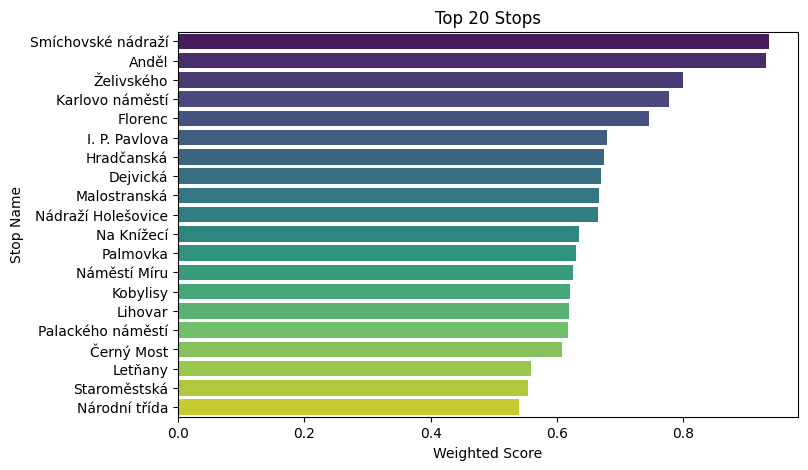

In [145]:
## plotting the top X stops ##
top_stops = best_stop.head(20)

plt.figure(figsize=(8,5))
sns.barplot(
    x='final_score',
    y='stop_name',
    data=top_stops,
    hue='stop_name',  # use y variable as hue
    dodge=False,
    palette='viridis',
    legend=False  # hides extra legend
)
plt.xlabel('Weighted Score')
plt.ylabel('Stop Name')
plt.title('Top 20 Stops')
plt.show()

### best stops by type of route (případně dodělat)

## BEST ROUTE

uses longest exposure + connects highly visited location - high repetition

formula:

$$ final.score = w_{duration} \cdot duration + w_{numstops} \cdot num.stops + w_{connection} \cdot connection - w_{repetition} \cdot repetition $$

plan:

1. normalise longest exposure, high repetition
2. create a dummy variable if connects stops in highly visited area
3. define weights
4. for each route compute its score
5. plot the resutls

In [166]:
## defining new dataset ##

# creating a new dataset
best_route = avg_duration_per_route[["route_id", "route_short_name"]].copy()

# normalising avg duration per route
best_route["duration"] = (avg_duration_per_route['duration_minutes'] - avg_duration_per_route['duration_minutes'].min()) / (
    avg_duration_per_route['duration_minutes'].max() - avg_duration_per_route['duration_minutes'].min())

# normalising number of stops
best_route["num_stops"] = (avg_stops_per_route['num_stops'] - avg_stops_per_route['num_stops'].min()) / (
    avg_stops_per_route['num_stops'].max() - avg_stops_per_route['num_stops'].min())

# connects stops in highly visited locations
best_route["good_loc"] = best_route['route_id'].isin(connected_routes).astype(int)

# normalising high repetition
best_route["repetition"] = (high_repetition['trip_id'] - high_repetition['trip_id'].min()) / (
    high_repetition['trip_id'].max() - high_repetition['trip_id'].min())

best_route.head(5)

,route_id,route_short_name,duration,num_stops,good_loc,repetition
0,L1106,T6,1.000000,1.000000,1,1.000000
1,L730,730,0.953947,0.965517,0,0.741467
2,L416,416,0.940789,0.896552,1,0.702977
3,L700,700,0.927632,0.862069,0,0.692084
4,L1110,T10,0.881579,0.862069,1,0.559187


In [167]:
## defining weights ##
w_duration = 0.4
w_numstops = 0.35
w_connection = 0.1
w_repetiton = 0.15

In [169]:
## computing final score for each route ##
best_route['final_score'] = (
    w_duration * best_route['duration'] +
    w_numstops * best_route['num_stops'] +
    w_connection * best_route['good_loc'] -
    w_repetiton * best_route['repetition']  # subtract penalty
)

best_route = best_route.sort_values("final_score", ascending=False).reset_index(drop = True)

In [170]:
best_route.head(10)

,route_id,route_short_name,duration,num_stops,good_loc,repetition,final_score
0,L1106,T6,1.000000,1.000000,1,1.000000,0.700000
1,L416,416,0.940789,0.896552,1,0.702977,0.684662
2,L1110,T10,0.881579,0.862069,1,0.559187,0.670478
3,L1226,R26,0.835526,0.810345,1,0.462600,0.648441
4,L1103,T3,0.736842,0.793103,1,0.421206,0.609142
5,L730,730,0.953947,0.965517,0,0.741467,0.608290
6,L1221,R21,0.684211,0.741379,1,0.332607,0.583276
7,L428,428,0.697368,0.741379,1,0.381990,0.581132
8,L1104,T4,0.684211,0.741379,1,0.351489,0.580444
9,L1102,T2,0.671053,0.724138,1,0.328976,0.572523


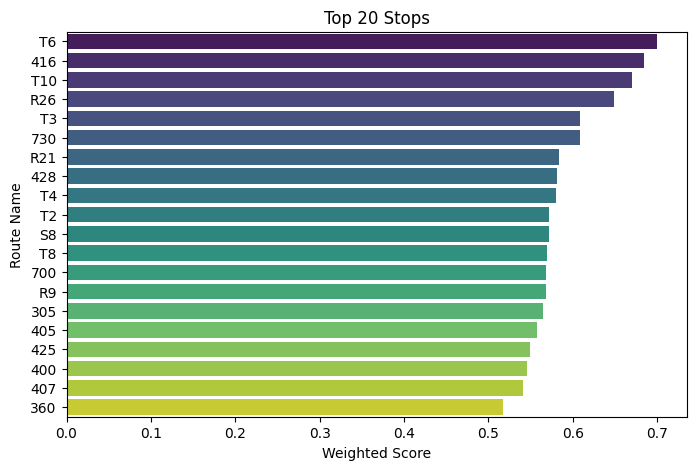

In [172]:
## plotting the top X stops ##
top_routes = best_route.head(20)

plt.figure(figsize=(8,5))
sns.barplot(
    x='final_score',
    y='route_short_name',
    data=top_routes,
    hue='route_short_name',  # use y variable as hue
    dodge=False,
    palette='viridis',
    legend=False  # hides extra legend
)
plt.xlabel('Weighted Score')
plt.ylabel('Route Name')
plt.title('Top 20 Stops')
plt.show()

### best routes by type (případně dodělat)

## NOTES

__TO DO (old)__

1. __high visibility:__
- sort by route type -> when one stop has metro, tram, and bus, do we just say that it's metro
- in other words, do we sort by metro > tram > trolley > bus (?)

2. __longest exposure__
- do we sort by route type, since now trains have the longest duration
- or just make exclude regional routes outside of Prague city (or if the route is at night)
- for the most amount of stops, do we once again sort by route type, or not

3. __highest repetition__
- do we sort for weekdays, weekends, full weeks
- and do we sort by route type

```text
my opinions:
1. i think the proposed [metro > tram > trolley > bus] system makes sense, but i would have to look into it a bit more, probably on saturday
2. i think we should exclude regional routes. i will look into doing that during processing, so we do not need to worry about it in the notebook file, i will report back tomorrow
3. i think we should sort by all weekdays combined as one output, by weekends as a second output and full weeks as a third output. 

- concerning sorting by route type, i think its an important distinction and it would probably be useful to provide separate outputs for each, both in longest exposure and highest repetition
```

__BEST STOPS__
- add in stops that have high repetition

__BEST ROUTES__
- exclude regional trains
- maybe do it by weekdays or weekends